In [85]:
__author__ = 'Brian Shevitski'

#Display options
%matplotlib inline
import matplotlib
matplotlib.rcParams.update(
    {'figure.figsize': (8,8)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import hyperspy.api as hs #io package for .dm3 data type
from hyperspy.misc.utils import DictionaryTreeBrowser
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle

from scipy.ndimage.filters import median_filter,gaussian_filter
from scipy.ndimage.measurements import center_of_mass
from scipy.optimize import curve_fit
from scipy.ndimage.interpolation import geometric_transform

import os

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

def topolar(img, order=1):
    """
    Transform img to its polar coordinate representation.

    order: int, default 1
        Specify the spline interpolation order. 
        High orders may be slow for large images.
    """
    # max_radius is the length of the diagonal 
    # from a corner to the mid-point of img.
    max_radius = 0.5*np.linalg.norm( img.shape )

    def transform(coords):
        # Put coord[1] in the interval, [-pi, pi]
        theta = 2*np.pi*coords[1] / (img.shape[1] - 1.)

        # Then map it to the interval [0, max_radius].
        #radius = float(img.shape[0]-coords[0]) / img.shape[0] * max_radius
        radius = max_radius * coords[0] / img.shape[0]

        i = 0.5*img.shape[0] - radius*np.sin(theta)
        j = radius*np.cos(theta) + 0.5*img.shape[1]
        return i,j

    polar = geometric_transform(img, transform, order=order)

    rads = max_radius * np.linspace(0,1,img.shape[0])
    angs = np.linspace(0, 2*np.pi, img.shape[1])

    return polar, (rads, angs)


In [61]:
#find .dm3 data files
filelist = []
for root,dirs,files in os.walk(os.getcwd()):
    for name in files:
        if '.dm3' in name:  
            filelist.append(os.path.join(root,name))
filelist

['/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/04 nbd cl4 spot 1nm.dm3',
 '/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/04 nbd cl4 spot 1nm.dm3',
 '/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/05 nbd 30 cm.dm3',
 '/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 3.dm3',
 '/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 40cm aperture 3.dm3']

In [62]:
dp = hs.load(filelist[0])
dat=dp.data.astype('float64')

In [109]:
class diffraction_pattern:
    """
    Loads,filters,centers, and averages .dm3 diffraction pattern data 
    """
    def __init__(self,fname):
        print('\n')
        self.fname = fname
        self.metadata = DictionaryTreeBrowser()
        self.centered = False
        if os.path.isfile(fname) == False:
            raise FileNotFoundError('File does not Exist!')
        self.hspy_obj = hs.load(fname)
        self.data = np.copy(self.hspy_obj.data.astype('float64'))
        self.filtered_data = self.data
        
        self.metadata.img_size_x = len(self.data[0])
        self.metadata.img_size_y = len(self.data)
        
        self.pixel_scale = self.hspy_obj.axes_manager[0].scale
        self.pixel_unit = self.hspy_obj.axes_manager[0].units
        
    def run_filters(self,median_filter_size=3,gaussian_filter_size=10,offset=0.01): #set kwargs for median and/or offset to 0 to not filter
        #self.filtered_data = np.copy(self.data)
        if median_filter_size != 0:
            self.data = median_filter(self.filtered_data,median_filter_size) #median filter for hot pixels
        if offset != 0:
            self.data = self.data - self.data.ravel().min() + offset #removes any negative pixels  or intensity offset
        self.gaussian_sigma = gaussian_filter_size
        self.filtered_data = gaussian_filter(self.data,gaussian_filter_size)
        
    def find_center(self,plot=True,search_box0=512,search_box1=256):
        self.centroid0 = np.array(center_of_mass(self.filtered_data))
        self.xmin0 = int((self.centroid0-[search_box0/2,search_box0/2])[1])
        self.xmax0 = int((self.centroid0+[search_box0/2,search_box0/2])[1])
        self.ymin0 = int((self.centroid0-[search_box0/2,search_box0/2])[0])
        self.ymax0 = int((self.centroid0+[search_box0/2,search_box0/2])[0])
        self.crop0 = self.filtered_data[self.ymin0:self.ymax0,self.xmin0:self.xmax0]
        
        self.centroid1 = np.array(center_of_mass(self.crop0))
        self.xmin1 = int((self.centroid1-[search_box1/2,search_box1/2])[1])
        self.xmax1 = int((self.centroid1+[search_box1/2,search_box1/2])[1])
        self.ymin1 = int((self.centroid1-[search_box1/2,search_box1/2])[0])
        self.ymax1 = int((self.centroid1+[search_box1/2,search_box1/2])[0])
        self.crop1 = self.crop0[self.ymin1:self.ymax1,self.xmin1:self.xmax1]
        
        if plot:
            fig,ax = plt.subplots(1,1)
            ax.imshow(np.log(self.data),cmap='viridis')
            ax.set_title('Central Spot Location Search',fontsize=18)
            rect0 = Rectangle([self.xmin0,self.ymin0],search_box0,search_box0,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect0)
            rect1 = Rectangle(np.array([self.xmin0,self.ymin0])+self.centroid1-[search_box1/2,search_box1/2],search_box1,search_box1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect1)
            plt.show()
            
    def fit_center(self,plot=True,print_params=True):
        # Create x and y indices
        x = np.arange(0, len(self.crop1[0]), 1)
        y = np.arange(0, len(self.crop1), 1)
        x,y = np.meshgrid(x, y)

        #amplitude center_x, center_y, sigma_x, sigma_y, theta, offset 
        #parameters are estimated as:
        #Amplitude = Max Value
        #center_x, center_y = middle pixel
        #sigma_x, sigma_y = sigma for gaussian blur
        #theta = 0
        #offset = Min Value
        self.p0 = [self.crop1.max(),len(x)/2,len(y)/2,self.gaussian_sigma,self.gaussian_sigma,0,self.crop1.min()]

        #Non-Linear LSq fitting
        self.coeff, self.var_matrix = curve_fit(twoD_Gaussian, (x, y), self.crop1.ravel(), p0=self.p0)
        self.data_fitted = twoD_Gaussian((x, y), *self.coeff)
        
        self.center = np.array([self.xmin0+self.xmin1,self.ymin0+self.ymin1])+np.array([self.coeff[1],self.coeff[2]])
        sq = min([min([self.center[0],len(self.data[0])-self.center[0]]),min([self.center[1],len(self.data)-self.center[1]])])
        self.center_crop = self.data[int(self.center[1]-sq):int(self.center[1]+sq),int(self.center[0]-sq):int(self.center[0]+sq)]
        
        if plot:
            fig,ax = plt.subplots(1,1)
            ax.set_title('2D Gaussian Fit to Center',fontsize=18)
            ax.imshow(self.crop1, cmap = 'viridis', origin = 'bottom',extent=(x.min(), x.max(), y.min(), y.max()))
            ax.contour(x, y, self.data_fitted.reshape(len(x),len(y)), 6, colors='r')
            plt.show()
        if print_params:
            print("Amplitude [Counts]: "+ str(self.coeff[0]))
            print("Center X [pix]: "+ str(self.coeff[1]))
            print("Center Y [pix]: "+ str(self.coeff[2]))
            print("Sigma X [pix]: "+ str(self.coeff[3]))
            print("Sigma Y[pix]: "+ str(self.coeff[4]))
            print("Theta [Deg]: "+ str(180/np.pi*self.coeff[5]))
            print("Offset [Counts]: "+ str(self.coeff[6]))

    def run_all(self,plot=True):
        self.centered = True
        self.run_filters()
        self.find_center(plot=plot)
        self.fit_center(plot=plot,print_params=plot)
        
        if plot:
            fig,ax = plt.subplots(1,1)
        
            ax.imshow(np.log(self.center_crop),cmap = 'viridis')
            ax.set_title('Centered, Filtered, and Cropped',fontsize=18)
        
            radius = 650
            circ = Circle(np.array([len(self.center_crop[0])/2,len(self.center_crop)/2]),radius,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(circ)
            plt.show()
       
    def get_polar(self,plot=True,vmin=0,vmax=10): #slow
        if self.centered:
            self.pol, (self.rads,self.angs) = topolar(self.center_crop)
        else:
            print('Run run_all() first')
        
        x0 = -len(self.center_crop)*self.pixel_scale/2
        step = 2
        tick_calib = np.arange(np.ceil(x0),np.floor(abs(x0))+step,step).astype(int)
        tick = (tick_calib - x0)/self.pixel_scale
        
        rad_step = 1 
        rads_cal = np.sqrt(2)*np.abs(x0)/len(self.rads)
        rads_tick_calib = np.arange(0,np.floor(abs(x0)*np.sqrt(2))+rad_step,rad_step).astype('int')
        rads_tick = rads_tick_calib/rads_cal
        
        if plot:
            
            fig,ax = plt.subplots(1,2,figsize=(16,8))

            ax[0].imshow(np.log(self.center_crop), cmap=plt.cm.cubehelix_r, interpolation='bicubic',vmin=vmin,vmax=vmax,origin="lower")
            ax[0].set_title("Cartesian Coordinates")

            ax[0].set_xticks(tick)
            ax[0].set_xticklabels(tick_calib)
            ax[0].set_xlabel("Radius in nm-1")
            ax[0].set_ylabel("Radius in pixels")

            ax[1].imshow(np.log(self.pol), cmap=plt.cm.cubehelix_r, interpolation='bicubic',vmin=vmin,vmax=vmax,origin="lower")
            ax[1].set_title("Polar Coordinates")

            ax[1].set_ylabel("Radius in nm-1")
            ax[1].set_yticks(rads_tick)
            ax[1].set_yticklabels(rads_tick_calib)

            ax[1].set_xlabel("Angle in degrees")
            ax[1].set_xticks(range(0, self.center_crop.shape[1]+1, int(len(self.angs)/12)))
            ax[1].set_xticklabels(np.arange(0,360+30,30))

            plt.show()

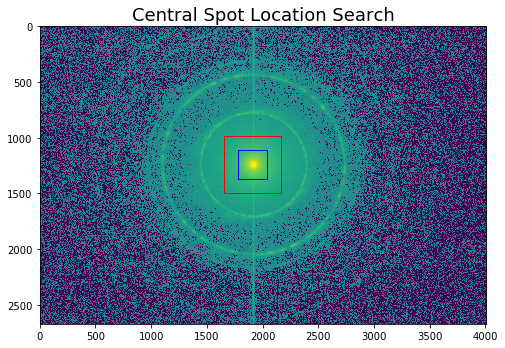

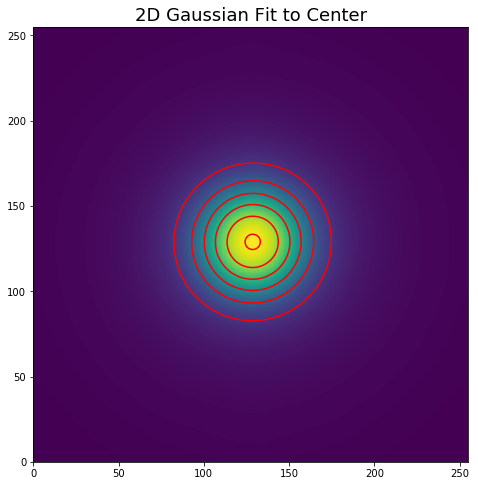

Amplitude [Counts]: 29800.266982459485
Center X [pix]: 128.62967549994687
Center Y [pix]: 128.94715008408986
Sigma X [pix]: 23.47360931206498
Sigma Y[pix]: 23.316930627758833
Theta [Deg]: -52.50969029553511
Offset [Counts]: 747.399956538878


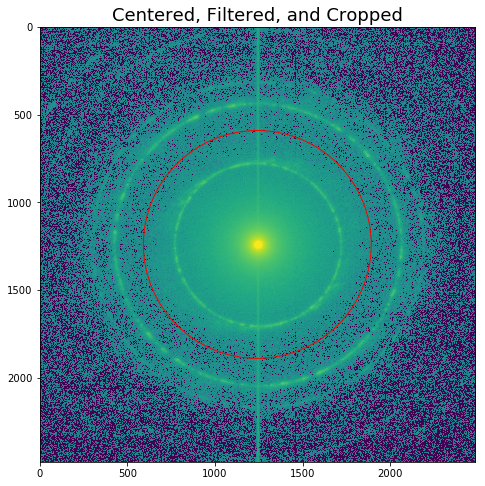

/Users/mofo/anaconda/envs/hyperspy/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in log


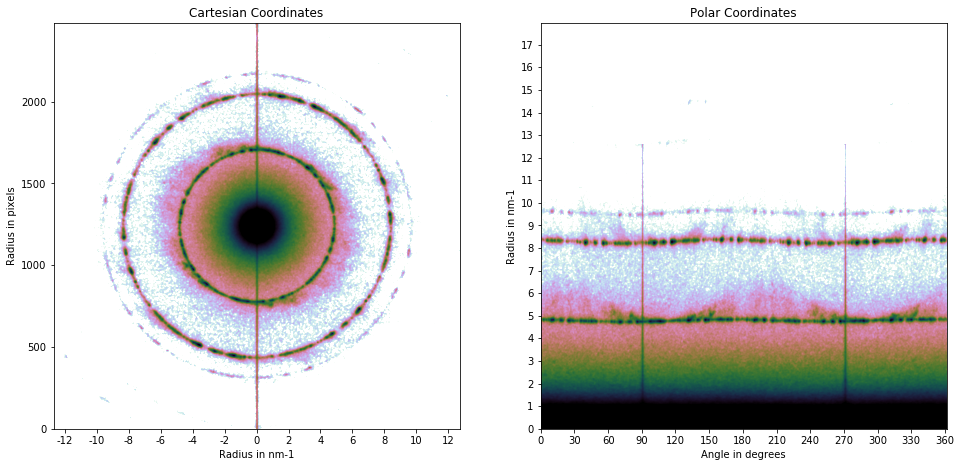

In [113]:
#use case

dp = diffraction_pattern(filelist[0])
dp.run_all()
dp.get_polar(vmin=2,vmax=6.5)